In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, fbeta_score
from sklearn.metrics import plot_confusion_matrix
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/simran.tyagi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
%run ./_preprocess.ipynb

#ds_root = '/home/gaurav.gupta/projects/PoCs/brandMention/brand_datasets/'
#r_path = os.path.join(ds_root, 'ds_complaints', 'panasonic_random_sample_predicted.csv')
#r_df = read_file(r_path)

#m_path = os.path.join(ds_root, 'ds_complaints', 'panasonic_v1_g.csv')
#m_df = read_file(m_path)

#raw_df = pd.concat([r_df, m_df])
#raw_df.reset_index(drop=True, inplace=True)
raw_df = pd.read_csv('/home/simran.tyagi/Downloads/panasonic_v1_f.csv')

options = {
    'handle_unicode': True,
    'handle_emoji': True,
    'handle_email': True,
    'handle_username': True,
    'handle_hashtags': True,
    'handle_url': True,
    'handle_markup': True,
    'handle_retweet': True,
    'handle_case': True,
    'handle_lemmatization': True,
    'handle_stopwords': True,
    'handle_punctuation': True,
    'handle_contractions': True,
    'print_stats': True
}
df = process_data(raw_df, **options)

# replace placeholders.
df.text = df.text.str.replace('HASHTAG', '', )
df.text = df.text.str.replace('HANDLE', '')
df.text = df.text.str.replace('URL', '')
df.text = df.text.str.replace('rt', '')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/simran.tyagi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


------------------  -----------  ------------
Step                Total words  Unique words
Start               77684        20298
Remove Retweet      66365        18469
Lower               66365        16577
Remove Retweet      66649        16528
Lemmatize           66649        15775
Unicode Fix         66656        15752
Replace emoji       67043        15848
Stop words          50235        15273
Email Replace       50235        15266
UserName replace    50921        14248
HashTags Replace    64615        10461
URL Replace         64615        8398
MARKUP Replace      64615        8397
Remove punctuation  64615        6668
------------------  -----------  ------------


In [17]:
tfidf = TfidfVectorizer(lowercase=False, max_df=.8, min_df=0.01, ngram_range=(1, 2))  
tfidf_wm = tfidf.fit_transform(df['text']).toarray() 
print(tfidf_wm.shape)
x_train, x_test, y_train, y_test = train_test_split(tfidf_wm, df['Complaint'], random_state = 42) 


(2421, 233)


---------------  -----------------
Metric           Score
Accuracy         91.74917491749174
F1 Score         75.96153846153847
F-Beta Score     85.31317494600432
Precision Score  64.22764227642277
Recall Score     92.94117647058823
---------------  -----------------


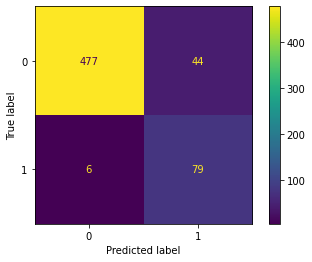

In [14]:
from sklearn.svm import SVC
from tabulate import tabulate


def test_model(model):
    pred_test = model.predict(x_test)
    model_acc_score = accuracy_score(y_test, pred_test)
    model_f1_score = f1_score(y_test, pred_test)
    model_prec_score = precision_score(y_test, pred_test)
    model_recall_score = recall_score(y_test, pred_test)
    model_f2_score = fbeta_score(y_test, pred_test, beta=2)
    results = []
    results.append(('Metric',   'Score'))
    results.append(('Accuracy', model_acc_score*100))
    results.append(('F1 Score', model_f1_score*100))
    results.append(('F-Beta Score', model_f2_score*100))
    results.append(('Precision Score', model_prec_score*100))
    results.append(('Recall Score', model_recall_score*100))
    print(tabulate(results))
    return pred_test

svc_model = SVC(kernel='linear', C=9, random_state=42,class_weight = 'balanced')
svc_model.fit(x_train, y_train)
pred_test = test_model(svc_model)
plot_confusion_matrix(svc_model, x_test, y_test)


In [15]:
svc_model.get_params()

{'C': 9,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [16]:
import shutil
%run ./_preprocess.ipynb

root = '/home/simran.tyagi/brand_ml'
model_dict = OrderedDict({'classifier': svc_model, 'vectorizer': tfidf})
# experiment_name = "<Algo_name>_<MetricName>_<NGrams>_<MetricValue>_<date>"
experiment_name = "SVC_FBeta_Biigram_8531_Jan05"
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
experiment_results = {
    "tn": float(tn), "fp": float(fp), "fn": float(fn), "tp": float(tp),
    "model_acc_score": float(accuracy_score(y_test, pred_test)),
    "model_f1_score": float(f1_score(y_test, pred_test)),
    "model_prec_score": float(precision_score(y_test, pred_test)),
    "model_recall_score": float(recall_score(y_test, pred_test)),
    "model_f2_score": float(fbeta_score(y_test, pred_test, beta=2)),
}

notes = {'details': ['Uni Model', 'SVM']}

# SAVE THE EXPERIMENT ARTIFACTS
shutil.rmtree(os.path.join(root, 'experiments',
              experiment_name), ignore_errors=True)
save_experiment(experiment_name, model_dict, tags=notes,
                results=experiment_results, preprocess_details=options)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/simran.tyagi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
